In [13]:
import random
from jupyturtle import *

def draw_plant(instructions, angle, length, angle_var=5, length_decay=0.8):
    make_turtle(delay=0, width=300, height=500)
    set_heading(270)
    jp(150, 480)
    set_color("gray")
    hide()

    stack = []
    for cmd in instructions:
        if cmd == 'F':
            fd(length)
        elif cmd == '+':
            rt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '-':
            lt(angle + random.uniform(-angle_var, angle_var))
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)

def draw_plant_contextual(instructions, angle, length, length_decay=0.8):
    make_turtle(delay=0, width=400, height=400)
    set_heading(270)
    jp(200, 380)
    set_color("gray")
    hide()

    stack = []
    last_cmd = '1'
    for cmd in instructions:
        if cmd == '1' or cmd == '0':
            fd(length)
            last_cmd = cmd
        elif cmd == '[':
            t = get_turtle()
            stack.append((t.position, t.heading, length))
            direction = 1 if last_cmd == '1' else -1
            set_heading(t.heading + (angle * direction))
            length *= length_decay
        elif cmd == ']':
            pos, head, length = stack.pop()
            jp(pos.x, pos.y)
            set_heading(head)


In [14]:
import random

def gen_lsystem_stochastic(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        next_str = []
        for char in current:
            if char in rules:
                if isinstance(rules[char], list):
                    next_str.append(random.choice(rules[char])) # stochastic choice
                else:
                    next_str.append(rules[char])
            else:
                next_str.append(char) # might not need this
        current = ''.join(next_str)
    return current

def gen_plant_stochastic():
    config = {
        'axiom': 'F',
        'rules': {
            'F': ['F[+F]F[-F]F', 'F[+F]F', 'F[-F]F'],  # stochastic branching
            'X': 'F[@-FX]+FX'  # flower production rule
        },
        'iterations': 4,
        'angle': 30,
        'length': 15,
        'thickness': 5,
        'angle_var': 10,
        'length_decay': 0.7
    }
    generated_string = gen_lsystem_stochastic(config['axiom'], config['rules'], config['iterations'])
    print(generated_string)    
    draw_plant(generated_string, config['angle'], config['length'], config['angle_var'], config['length_decay'])
    return generated_string

In [15]:
def get_context(c_string, idx):
    env_context = '1'
    ignore = ['[', ']', '+', '-']

    # find left context
    left_context = env_context
    i = idx
    while i > 0:
        if c_string[i-1] in ['+', '-']:   # left neighbor is a pitch modifier
            i -= 1
        else:
            if c_string[i-1] == '[':          # left neighbor is an opening bracket
                depth = 0
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == ']':
                        depth += 1
                    elif c_string[j] == '[':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            elif c_string[i-1] == ']':        # left neighbor is a closing bracket
                depth = -1
                j = i - 2
                while j >= 0 and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j -= 1
                if j >= 0:
                    left_context = c_string[j]
            else:                             # left neighbor is a normal character
                left_context = c_string[i-1]
            break
    
    # find right context
    right_context = env_context
    i = idx
    while i < len(c_string) - 1:
        if c_string[i+1] in ['+', '-']:       # right neighbor is a pitch modifier
            i += 1
        else:
            if c_string[i+1] == ']':          # right neighbor is a closing bracket
                right_context = env_context
            elif c_string[i+1] == '[':        # right neighbor is an opening bracket
                depth = 1
                j = i + 2
                while j < len(c_string) and (depth != 0 or c_string[j] in ignore):
                    if c_string[j] == '[':
                        depth += 1
                    elif c_string[j] == ']':
                        depth -= 1
                    j += 1
                if j < len(c_string):
                    right_context = c_string[j]
            else:                             # right neighbor is a normal character
                right_context = c_string[i+1]
            break
    
    return left_context, c_string[idx], right_context

def gen_lsystem_contextual(axiom, rules, iterations):
    current = axiom
    for _ in range(iterations):
        # print(f'\ncurrent: \"{current}\"')
        next_str = []
        for i, char in enumerate(current):
            if char not in ['[', ']', '+', '-']:
                context = get_context(current, i)
                if context in rules:
                    # print(f'index: {i}, char: {char}, context: {context} ==> \'{rules[context]}\'')
                    next_str.append(rules[context])
                else:
                    print(f'!!! No rule for {context}')
            elif char in ['+', '-']:
                next_str.append(rules[char])
            else:
                next_str.append(char)
        current = ''.join(next_str)
    return current

def gen_plant_contextual():
    config = {
        'axiom': '011',
        'rules': {
            ('0', '0', '0'): '1',
            ('0', '0', '1'): '0',
            ('0', '1', '0'): '0',
            ('0', '1', '1'): '11',
            ('1', '0', '0'): '1',
            ('1', '0', '1'): '1[+1]',
            ('1', '1', '0'): '1',
            ('1', '1', '1'): '0',
            '+': '-',
            '-': '+',
        },
        'iterations': 17,
        'angle': 45,
        'length': 11,
        'thickness': 5,
        'length_decay': 0.75
    }
    generated_string = gen_lsystem_contextual(config['axiom'],
                                           config['rules'],
                                           config['iterations'])
    print(generated_string)    
    draw_plant_contextual(generated_string, config['angle'],
                                            config['length'],
                                            config['length_decay'])
    return generated_string

In [16]:
generated_string = gen_plant_contextual()

1[+11[-0]011[-11[-1[+1]]]0[-0[-0]]11[+1[+1]][-1[+1]111[+01[-00[-00[-1[-0]]]]]]]1[+11[-1[+1]]][-11[-0]000[-1[-1[+1]]]1[-1[+1]]1[+1]1111[+0[-0]]011[+11[+110[+00[+00[+1[+1]]]]]]]10110[-0][+1[+1]1101[-1[-11[-0]]]]0000[-1[+1]]0011[+1][-0][-110[+1[+1]]][+110[+1[-0]]][+111[+1[+1]]1[+1]110[-0]00[+1[+0]][-11[-11[-11[-0]]]]][-111[+1[+1]]1[+1]1100[+01[+1[+1]]][-1[+1]0[+000[+1[+1[+1]]]]]][-1111[+1][-0111[-0[-1[+1]]]]1111[+0]1110[+0][+11[-0]][-11[-1[+1]]][-11[-0]0111[-11[-0]][+0[-0]1[+1][+11[+1[+1]]]]][+10110[-0][+1[+1]][+011[+1][-11[-0]]][+000[-1[-0]]0011[+1][-0][-110[+1[+1]]][+1111[+1][+0][+0110[-0][+00[+1[+1]]]]]]]]


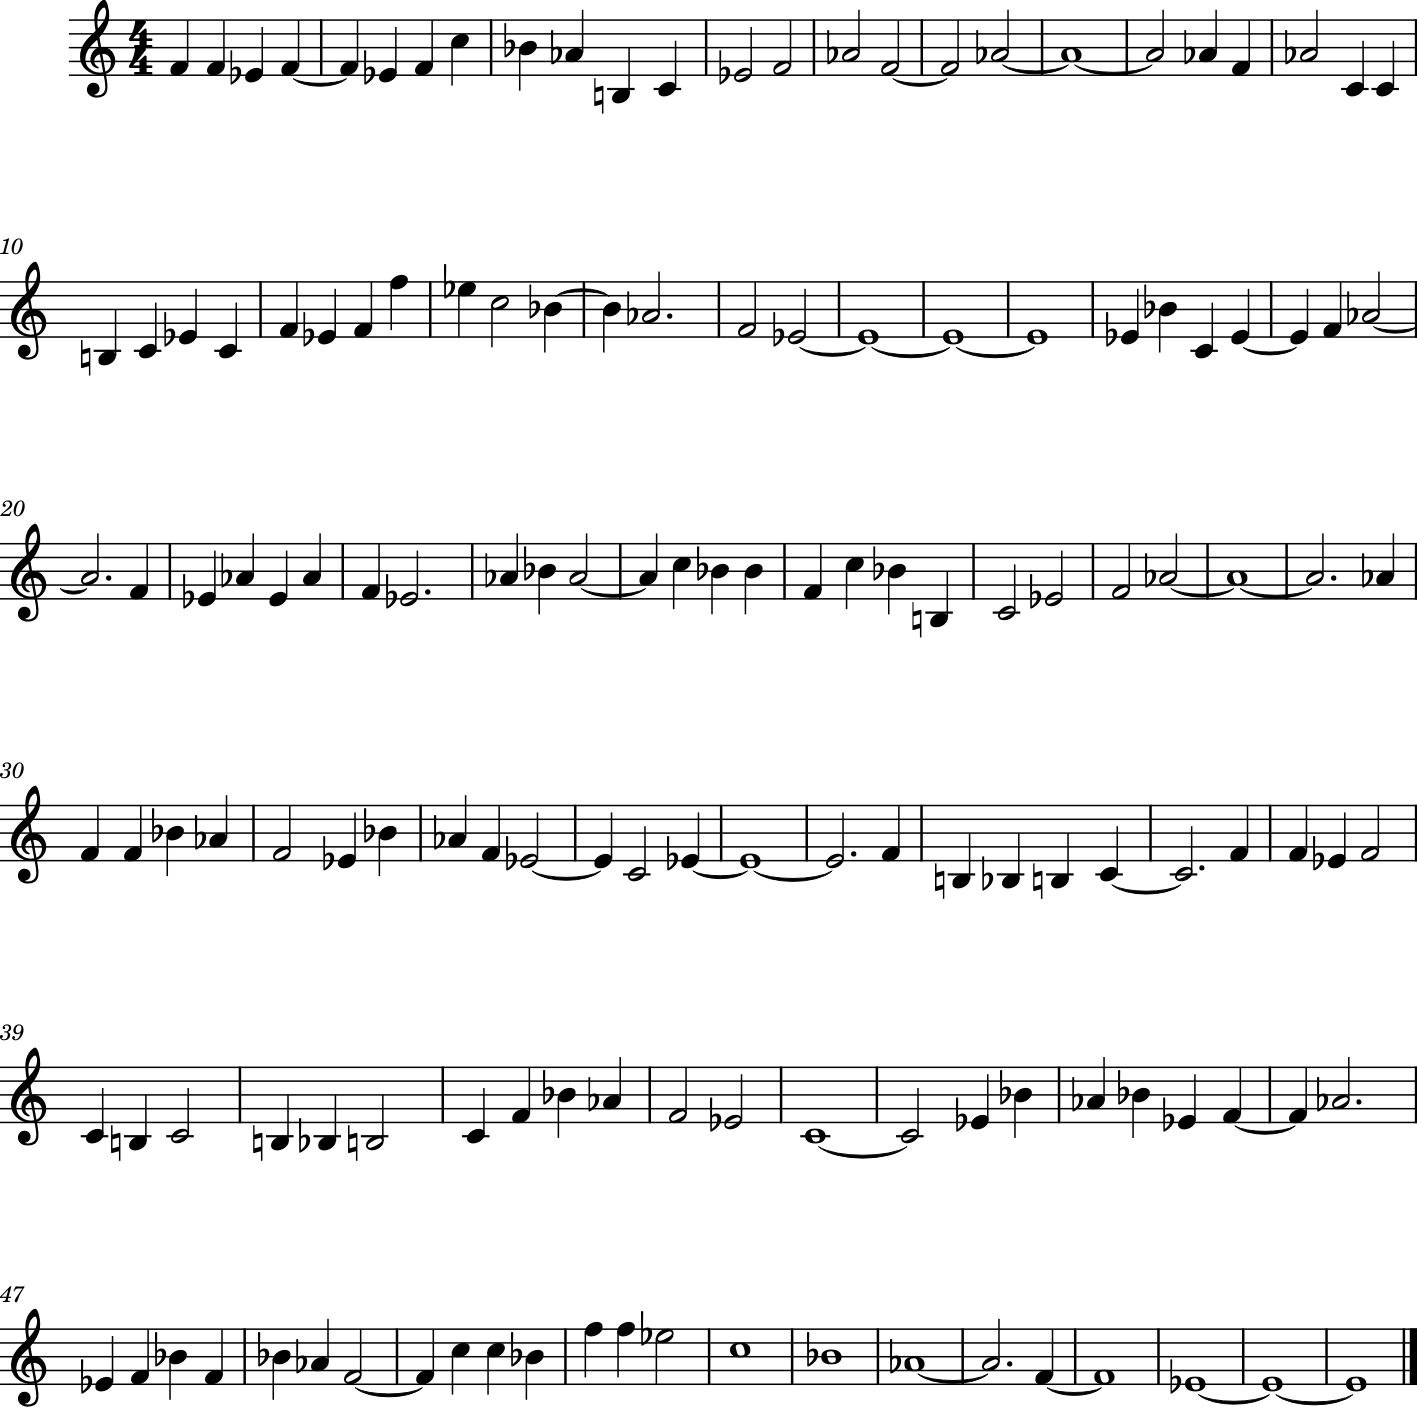

In [17]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"
us['musicxmlPath'] = "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe"

def generate_music_stochastic(lsystem_string):
    s1 = stream.Stream()
    f_major = scale.WeightedHexatonicBlues('F')
    scale_notes = f_major.getPitches('F3', 'F5')
    current_note_idx = len(scale_notes) // 2  # Start in middle of range
    current_duration = 0
    stack = []

    # Process each character in the L-system string
    for char in lsystem_string:
        if char == '1' or char == '0':
            current_duration += 1.0  # Add quarter note duration
            last_cmd = char
        elif char == '+':
            current_note_idx = min(current_note_idx + 1, len(scale_notes) - 1)
        elif char == '-':
            current_note_idx = max(current_note_idx - 1, 0)
        elif char == '[':
            stack.append((current_note_idx, current_duration, last_cmd))
            current_duration = 0
        elif char == ']':
            if current_duration > 0:
                n = note.Note(scale_notes[current_note_idx], quarterLength=current_duration)
                s1.append(n)
            current_note_idx, current_duration, last_cmd = stack.pop()
        # 'X' is ignored as per specification

    return s1

s1 = generate_music_stochastic(generated_string)

s1.show()

In [18]:
for element in s1.recurse():
    if hasattr(element, 'duration'):
        element.duration.quarterLength /= 2.0
    if hasattr(element, 'offset'):
        element.offset /= 4.0

s1.write('midi', 'comp1.mid')
s1.show('midi')